# PHY 604: Homework #6 Solutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<div style="background-color: powderblue; color: black; padding: 10px;">

1. _Faraday cage_ The electric
  potential satisfies a Poisson equation:
  \begin{equation}
    \nabla^2 \phi = \frac{\rho_c}{\epsilon_0}
  \end{equation}
  where $\rho_c$ is the charge density and $\epsilon_0$ is the permittivity of v
acuum.

  Consider a simple Faraday cage (we are representing this as a 2-d
  plane).  We have a unit-square box with 8 grounded points (you can
  think of these as wires running out of the page).  The configuration 
  appears as follows:
  ![cage](cage.png)

  The potential on the 4 sides of the domain are as shown in the
  figure.  The interior points (wires) are at:
  (1/3, 2/3), (1/2, 2/3), (2/3, 2/3), (1/3, 1/2), (2/3, 1/2), (1/3, 1/3), (1/2, 1/3), (2/3, 1/3)
  

  <p>Since there are no charges, we are just solving $\nabla^2 \phi = 0$
  and the plates act as additional boundaries.

  <p>You can use either a node-centered or cell-centered grid.  Solve for
  the potential in the domain using smoothing/relaxation.  For either
  choice of grid, implement the wires as simply the values of the
  potential at the points in the grid matching the geometry defined
  above.  These points should not be updated during the
  relaxation---just keep them fixed at $\phi = 0$.  

  <p>To check for convergence, check
  the norm of the residual, and continue smoothing until the error is
  less than $10^{-6}$.  Note: do not compute a residual in the zones
  occupied by the plates.

  <p>Plot the potential, and optionally the electric field, ${\bf E} =
  -\nabla \phi$.



</div>

We'll create a class to manage the domain and keep track of the interior points.  Our strategy is to do smoothing on all points in the domain except for the 8 interior points.  For the boundary conditions, we'll use ghost cells, initialized such that the average of them and the corresponding interior point gives the desired boundary value.

In [2]:
class FaradayCage(object):

    def __init__(self, N):
        self.nx = N
        self.ny = N
        self.ng = 1

        self.phi = np.zeros((self.nx + 2*self.ng, self.ny + 2*self.ng),
                            dtype=np.float64)
        self.r = np.zeros_like(self.phi)

        self.ilo = self.ng
        self.ihi = self.ng + self.nx - 1

        self.jlo = self.ng
        self.jhi = self.ng + self.ny - 1

        self.xmin = self.ymin = 0.0
        self.xmax = self.ymax = 1.0

        self.dx = (self.xmax - self.xmin)/self.nx
        self.dy = (self.ymax - self.ymin)/self.ny

        self.x = (np.arange(self.nx + 2*self.ng) + 0.5 - self.ng)*self.dx + self.xmin
        self.y = (np.arange(self.ny + 2*self.ng) + 0.5 - self.ng)*self.dy + self.ymin

        self.x2d = np.repeat(self.x, self.ny + 2*self.ng)
        self.x2d.shape = (self.nx + 2*self.ng, self.ny + 2*self.ng)

        self.y2d = np.repeat(self.y, self.nx + 2*self.ng)
        self.y2d.shape = (self.ny + 2*self.ng, self.nx + 2*self.ng)
        self.y2d = np.transpose(self.y2d)

        # wire indices
        self.wires = [(N//3, 2*N//3), (N//2, 2*N//3), (2*N//3, 2*N//3),
                      (N//3, N//2),                   (2*N//3, N//2),
                      (N//3, N//3),   (N//2, N//3),   (2*N//3, N//3)]


        # set the potential on the wires -- set it and forget it --
        # we don't update these zones subsequently
        for i, j in self.wires:
            self.phi[i, j] = 0.0


    def check_wire(self, i, j):
        """ determine if we are a zone that is a wire """
        return (i, j) in self.wires


    def smooth(self):

        err = 1.e30
        tol = 1.e-6

        while err > tol:

            # fill the ghost cells
            self.phi[self.ilo-1,:] = -self.phi[self.ilo,:]
            self.phi[self.ihi+1,:] = 2 - self.phi[self.ihi,:]

            self.phi[:,self.jlo-1] = 2*self.x[:] - self.phi[:,self.jlo]
            self.phi[:,self.jhi+1] = 2*self.x[:] - self.phi[:,self.jhi]

            for i in range(self.ilo, self.ihi+1):
                for j in range(self.jlo, self.jhi+1):

                    # if this zone is a wire, don't update
                    if self.check_wire(i,j):
                        continue

                    # update phi[i,j]
                    self.phi[i,j] = 0.25*(self.phi[i-1,j] + self.phi[i+1,j] +
                                          self.phi[i,j-1] + self.phi[i,j+1])

            # the error is just the residual, L phi
            self.r[self.ilo:self.ihi+1,self.jlo:self.jhi+1] = \
                (-2.0*self.phi[self.ilo:self.ihi+1,self.jlo:self.jhi+1] +
                 self.phi[self.ilo+1:self.ihi+2,self.jlo:self.jhi+1] +
                 self.phi[self.ilo-1:self.ihi,self.jlo:self.jhi+1])/self.dx**2 + \
                (-2.0*self.phi[self.ilo:self.ihi+1,self.jlo:self.jhi+1] +
                 self.phi[self.ilo:self.ihi+1,self.jlo+1:self.jhi+2] +
                 self.phi[self.ilo:self.ihi+1,self.jlo-1:self.jhi])/self.dy**2

            for i, j in self.wires:
                self.r[i, j] = 0.0

            err = np.sqrt(self.dx*self.dy*np.sum((self.r[self.ilo:self.ihi+1,
                                                         self.jlo:self.jhi+1]**2).flat))

    def E_field(self):
        """ E = - grad phi """
        E_x = np.zeros_like(self.phi)
        E_y = np.zeros_like(self.phi)

        E_x[self.ilo:self.ihi+1,self.jlo:self.jhi+1] = \
            -0.5*(self.phi[self.ilo+1:self.ihi+2,self.jlo:self.jhi+1] - \
                  self.phi[self.ilo-1:self.ihi,self.jlo:self.jhi+1])/self.dx

        E_y[self.ilo:self.ihi+1,self.jlo:self.jhi+1] = \
            -0.5*(self.phi[self.ilo:self.ihi+1,self.jlo+1:self.jhi+2] - \
                  self.phi[self.ilo:self.ihi+1,self.jlo-1:self.jhi])/self.dy

        return E_x, E_y

Here we'll run a 64x64 domain and plot the potential

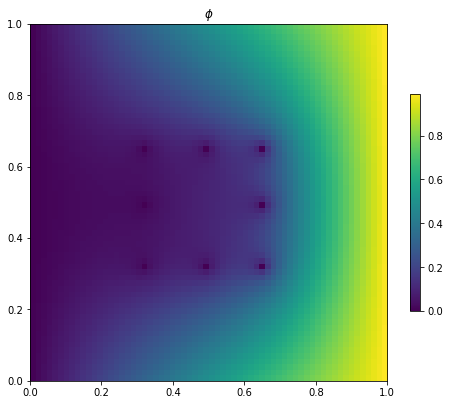

In [3]:
c = FaradayCage(64)
c.smooth()

plt.imshow(c.phi[c.ilo:c.ihi+1,c.jlo:c.jhi+1].T, origin="lower",
           cmap="viridis", extent=(c.xmin, c.xmax, c.ymin, c.ymax))
plt.colorbar(shrink=0.5)

f = plt.gcf()
f.set_size_inches(8.0, 8.0)

plt.title(r"$\phi$")

We included a method to compute the electric field as the gradient of the potential, so we visualize that here.

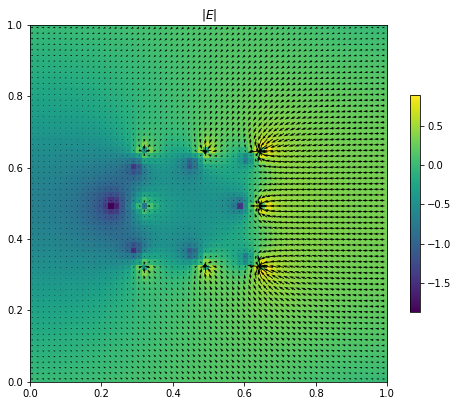

In [4]:
E_x, E_y = c.E_field()

plt.quiver(c.x2d.T, c.y2d.T, E_x.T, E_y.T)
plt.xlim(0, 1)
plt.ylim(0, 1)

Emag = np.sqrt(E_x**2 + E_y**2)

plt.imshow(np.log10(Emag[c.ilo:c.ihi+1,c.jlo:c.jhi+1].T), origin="lower", 
           cmap="viridis", extent=(c.xmin, c.xmax, c.ymin, c.ymax))
plt.colorbar(shrink=0.5)

f = plt.gcf()
f.set_size_inches(8.0, 8.0)

plt.title(r"$|E|$")

<div style="background-color: powderblue; color: black; padding: 10px;">
2. _Time-dependent diffusion_ (from Newman) Consider
  diffusion through the Earth's crust---this has a time-dependent
  boundary condition, the solar heating throughout the seasons.
  We'll model this in 1-d.

  <p>The temperature at the surface of the Earth is:
  \begin{equation}
    T_0(t) = A + B \sin \left(\frac{2\pi t}{\tau}\right)
  \end{equation}
  where $\tau = 365$~days, $A = 10^\circ$~C is the average temperature
  and $B = 12^\circ$~C captures the seasonal variation.

  <p>At a depth of 20~m, the temperature is relatively constant, which we
  take as $11^\circ$~C.  This temperature is set by the heat flux
  coming from the interior of the Earth. 

  <p>Take the thermal diffusivity of the Earth's crust as $D =
  0.1~\mathrm{m}^2~\mathrm{day}^{-1}$.
  
  <p>Solve the diffusion equation on a domain from the surface to a 
  depth of 20~m.  For the initial conditions, take $T = 10^\circ$~C
  in all the interior zones.  Evolve for 10 years---after a few
  years the initial guess at the temperature will have relaxed out. 
  
  <p>You'll need to pick a discretization, number of zones, and a
  timestep---use any of the methods we discussed in class.

  <p>For the final year, plot $T(x)$ at 4 different times (corresponding
  to the 4 seasons).  This will illustrate the seasonal variation of
  temperature with depth.



    </div>

Here's our grid class that manages the domain and the data that lives on the grid

In [5]:
class Grid(object):

    def __init__(self, nx, ng, 
                 xmin=0.0, xmax=1.0,
                 bc_lo_func=None, bc_hi_func=None):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx

        # python is zero-based.  Make easy intergers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords -- cell-centered
        self.dx = (xmax - xmin)/float(nx)
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx

        # storage for the solution
        self.T = np.zeros((nx+2*ng), dtype=np.float64)

        # boundary condition functions -- these take the time as
        # an argument and return the value of temperature on the
        # boundary
        self.bc_lo_func = bc_lo_func
        self.bc_hi_func = bc_hi_func        

    def scratch_array(self):
        """ return a scratch array dimensioned for our grid """
        return np.zeros((self.nx+2*self.ng), dtype=np.float64)

    def fill_BCs(self, t):
        """ time-dependent Dirichlet BCs """
        self.T[0:self.ilo]  = -self.T[self.ilo] + 2*self.bc_lo_func(t)
        self.T[self.ihi+1:] = -self.T[self.ihi] + 2*self.bc_hi_func(t)

We write boundary condition functions that take time as an argument to allow ourselves the flexibility to implement time-varying BCs

In [6]:
def bc_lo_func(t):
    # return the temperature in C at the lower boundary
    T_lo = 11
    return T_lo

def bc_hi_func(t):
    # return the temperature in C at the upper boundary
    A = 10
    B = 12
    tau = 365
    T_hi = A + B*np.sin(2.0*np.pi*t/tau)
    return T_hi

We'll solve this using a time-explicit discretization.

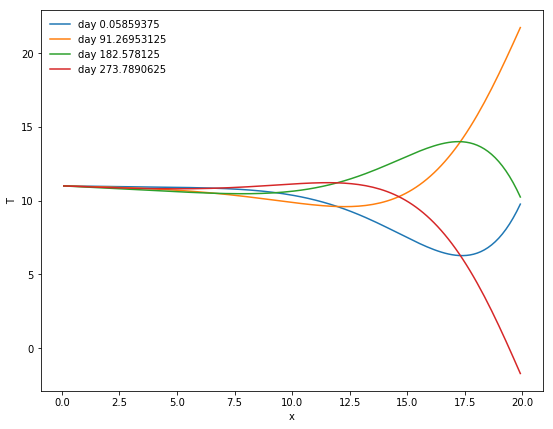

In [7]:
# create the grid -- domain size is in m
nx = 128
ng = 1

xmin = 0
xmax = 20
g = Grid(nx, ng, xmin=xmin, xmax=xmax, 
         bc_lo_func=bc_lo_func, bc_hi_func=bc_hi_func)

# initial temperature
T_0 = 10

# diffusion coefficient (this is in units of m^2/day)
D = 0.1

# time info
year = 365

C = 0.8
dt = C*0.5*g.dx**2/D
t = 0.0
tmax = 10.0*year

# initialize the data to a constant
g.T[:] = T_0

# evolution loop
phinew = g.scratch_array()

store_dt = 0.25*year
    
sols = []

while t < tmax:

    # make sure we end right at tmax
    if t + dt > tmax:
        dt = tmax - t

    # fill the boundary conditions
    g.fill_BCs(t)

    alpha = D*dt/g.dx**2

    # loop over zones
    for i in range(g.ilo, g.ihi+1):
        
        # explicit diffusion
        phinew[i] = g.T[i] + alpha*(g.T[i+1] - 2.0*g.T[i] + g.T[i-1])

        
    # do we save it?
    if t % store_dt < dt:
        sols.append((t, phinew.copy()))

    # update the solution
    g.T[:] = phinew[:]
    t += dt


for i in [-4, -3, -2, -1]:
    t, T = sols[i]
    plt.plot(g.x[g.ilo:g.ihi+1], T[g.ilo:g.ihi+1], label="day {}".format(t % year))

plt.xlabel("x")
plt.ylabel("T")

plt.legend(frameon=False)
f = plt.gcf()
f.set_size_inches(9.0, 7.0)